In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import sys
from bs4 import BeautifulSoup
#import geocoder
import os
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')
#Libraries imported.
#Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                       

In [2]:
!conda search geocoder --channel conda-forge

Loading channels: done
# Name                  Version           Build  Channel             
geocoder                 1.38.1            py_1  conda-forge         


In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

#We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude.
#Below function will return venue id , venue name and category.

In [4]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '##############' # changed my Foursquare ID
    CLIENT_SECRET = '#############' # changed Foursquare Secret
    VERSION = '20190505' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df


In [5]:
#Define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.


def get_venue_details(venue_id):
        
    CLIENT_ID = '#######' # i have changed the id with ##
    CLIENT_SECRET = '#########' # i have changed the secret with ##
    VERSION = '20190505' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

#define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.


In [6]:

from pandas.io.json import json_normalize

In [7]:


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data


#call the above funtion to get the new york city data.


# get new york data
new_york_data=get_new_york_data()
new_york_data.head(20)

Borough        Neighborhood   Latitude  Longitude
0       Bronx           Wakefield  40.894705 -73.847201
1       Bronx          Co-op City  40.874294 -73.829939
2       Bronx         Eastchester  40.887556 -73.827806
3       Bronx           Fieldston  40.895437 -73.905643
4       Bronx           Riverdale  40.890834 -73.912585
5       Bronx         Kingsbridge  40.881687 -73.902818
6   Manhattan         Marble Hill  40.876551 -73.910660
7       Bronx            Woodlawn  40.898273 -73.867315
8       Bronx             Norwood  40.877224 -73.879391
9       Bronx      Williamsbridge  40.881039 -73.857446
10      Bronx          Baychester  40.866858 -73.835798
11      Bronx      Pelham Parkway  40.857413 -73.854756
12      Bronx         City Island  40.847247 -73.786488
13      Bronx        Bedford Park  40.870185 -73.885512
14      Bronx  University Heights  40.855727 -73.910416
15      Bronx      Morris Heights  40.847898 -73.919672
16      Bronx             Fordham  40.860997 -73.896427
17      Bronx        East Tremont  40.842696 -73.887356
18      Bronx          West Farms  40.839475 -73.877745
19      Bronx        High  Bridge  40.836623 -73.926102

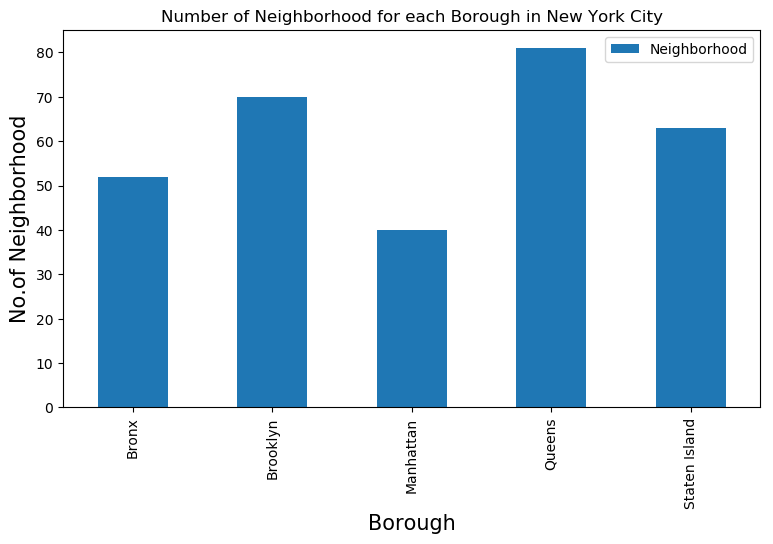

In [8]:
new_york_data.shape



plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [9]:
# collect Italian restaurants for each Neighborhood


# prepare neighborhood list that contains Italian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
Italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    Italian_restaurants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Italian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(Italian_restaurants)))
    for restaurant_detail in Italian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        Italian_rest_ny = Italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) Italian Restaurants in Wakefield, Bronx:0
done
( 2 / 306 ) Italian Restaurants in Co-op City, Bronx:0
done
( 3 / 306 ) Italian Restaurants in Eastchester, Bronx:0
done
( 4 / 306 ) Italian Restaurants in Fieldston, Bronx:0
done
( 5 / 306 ) Italian Restaurants in Riverdale, Bronx:1
done
( 6 / 306 ) Italian Restaurants in Kingsbridge, Bronx:1
done
( 7 / 306 ) Italian Restaurants in Marble Hill, Manhattan:0
done
( 8 / 306 ) Italian Restaurants in Woodlawn, Bronx:2
done
( 9 / 306 ) Italian Restaurants in Norwood, Bronx:0
done
( 10 / 306 ) Italian Restaurants in Williamsbridge, Bronx:0
done
( 11 / 306 ) Italian Restaurants in Baychester, Bronx:2
done
( 12 / 306 ) Italian Restaurants in Pelham Parkway, Bronx:3
done
( 13 / 306 ) Italian Restaurants in City Island, Bronx:3
done
( 14 / 306 ) Italian Restaurants in Bedford Park, Bronx:0
done
( 15 / 306 ) Italian Restaurants in University Heights, Bronx:0
done
( 16 / 306 ) Italian Restaurants in Morris Heights, Bronx:0
done
( 17 /

In [10]:
Italian_rest_ny.head()

Italian_rest_ny.shape

(525, 4)

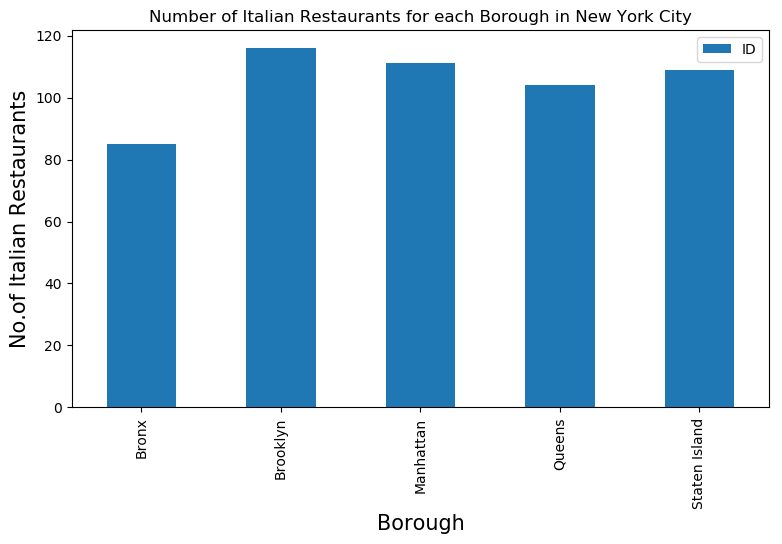

In [11]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Restaurants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Restaurants', fontsize=15)
#giving a bar plot
Italian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

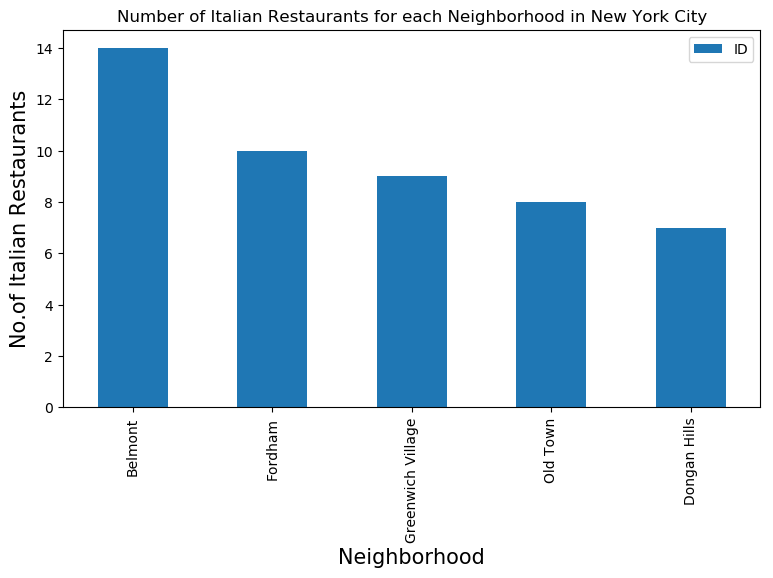

In [12]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Restaurants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Restaurants', fontsize=15)
#giving a bar plot
Italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [13]:
Italian_rest_ny[Italian_rest_ny['Neighborhood']=='Belmont']

Borough Neighborhood                        ID  \
45   Bronx      Belmont  4acf80aef964a52025d420e3   
46   Bronx      Belmont  59050f51b23dfa5f6649e678   
47   Bronx      Belmont  4af71916f964a520cf0522e3   
48   Bronx      Belmont  4bb6470cef159c7465b275f7   
49   Bronx      Belmont  4af0fa29f964a52060e021e3   
50   Bronx      Belmont  4a8e261cf964a5201c1220e3   
51   Bronx      Belmont  4b5514c4f964a5207cda27e3   
52   Bronx      Belmont  4aa425bef964a5208e4520e3   
53   Bronx      Belmont  4c79d294278eb713f6a05580   
54   Bronx      Belmont  4b5a4c8ff964a52049bb28e3   
55   Bronx      Belmont  4b5bc595f964a520431529e3   
56   Bronx      Belmont  4aa193d5f964a520124120e3   
57   Bronx      Belmont  4cb0d382ef1b370419643e00   
58   Bronx      Belmont  53ff939c498e6b601dfa3979   

                                                 Name  
45                                Tino's Delicatessen  
46                               Arthur Avenue Fiasco  
47  Michaelangelo's Coal Fired Brick Oven Pizza Re...  
48                                Calabria Pork Store  
49                                Antonio's Trattoria  
50                                          Roberto's  
51                                             Enzo's  
52                              Dominick's Restaurant  
53                                    Cafe al Mercato  
54                                Emilia's Restaurant  
55                              Pasquale Riggaletto's  
56                      Mario's Restaurant & Catering  
57              David Greco's Arthur Avenue Trattoria  
58                             San Gennaro Ristorante

In [14]:
# get the ranking of each restaurant for further analysis.

# prepare neighborhood list that contains Italian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
Italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in Italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these restaurants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(Italian_rest_ny),')','processed')
    Italian_rest_stats_ny = Italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

done
                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      9     7.3     4
( 1 / 525 ) processed
done
                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      9     7.3     4
( 2 / 525 ) processed
done
                         ID                    Name  Likes  Rating  Tips
0  511edb6de4b0d58346fd272d  Patrizia's Of Woodlawn     18     8.3    14
( 3 / 525 ) processed
done
                         ID         Name  Likes  Rating  Tips
0  4d3cb3026b3d236a066a6364  Rivers Edge     10     6.8     8
( 4 / 525 ) processed
done
                         ID        Name  Likes  Rating  Tips
0  4c9518076b35a143d5dc21dc  Fratelli's     22     8.5     6
( 5 / 525 ) processed
done
                         ID          Name  Likes  Rating  Tips
0  5411894d498e4a254a11a46c  Olive Garden     26     7.4     8
( 6 / 525 ) processed
done
                         ID    

KeyError: 'venue'

In [49]:
Italian_rest_stats_ny.head()
Italian_rest_stats_ny.shape
Italian_rest_ny.shape

Italian_rest_stats_ny.to_csv('Italian_rest_stats_ny.csv', index=False)
Italian_rest_stats_ny_csv=pd.read_csv('Italian_rest_stats_ny.csv')
Italian_rest_stats_ny_csv.shape
Italian_rest_stats_ny_csv.head()
Italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 7 columns):
Borough         450 non-null object
Neighborhood    450 non-null object
ID              450 non-null object
Name            450 non-null object
Likes           450 non-null float64
Rating          450 non-null float64
Tips            450 non-null float64
dtypes: float64(3), object(4)
memory usage: 24.7+ KB


In [50]:
Italian_rest_stats_ny.head(200)

Borough               Neighborhood                        ID  \
0        Bronx                  Riverdale  55aaee4d498e3cbb70e625d6   
1        Bronx                Kingsbridge  55aaee4d498e3cbb70e625d6   
2        Bronx                   Woodlawn  511edb6de4b0d58346fd272d   
3        Bronx                   Woodlawn  4d3cb3026b3d236a066a6364   
4        Bronx                 Baychester  4c9518076b35a143d5dc21dc   
5        Bronx                 Baychester  5411894d498e4a254a11a46c   
6        Bronx             Pelham Parkway  4bf96ae65317a593d837017f   
7        Bronx             Pelham Parkway  4b10591af964a5205f6e23e3   
8        Bronx             Pelham Parkway  4b47f069f964a5208c4426e3   
9        Bronx                City Island  4514ed4df964a520e5391fe3   
10       Bronx                City Island  55905336498e1a9217de2a7a   
11       Bronx                City Island  4b80a1c3f964a520488230e3   
12       Bronx                    Fordham  4acf80aef964a52025d420e3   
13       Bronx                    Fordham  4bb6470cef159c7465b275f7   
14       Bronx                    Fordham  59050f51b23dfa5f6649e678   
15       Bronx                    Fordham  4af71916f964a520cf0522e3   
16       Bronx                    Fordham  4b5514c4f964a5207cda27e3   
17       Bronx                    Fordham  4aa425bef964a5208e4520e3   
18       Bronx                    Fordham  4b5a4c8ff964a52049bb28e3   
19       Bronx                    Fordham  4c9b9e7b9c663704b90463fd   
20       Bronx                    Fordham  53ff939c498e6b601dfa3979   
21       Bronx                    Fordham  4bc67f1104e8b713a833362d   
22       Bronx                    Melrose  5956be26123a195de6701c2b   
23       Bronx                    Melrose  4bb692672ea19521a6ecab2f   
24       Bronx                 Mott Haven  4e6acfb1ae60950955a9b02b   
25       Bronx                 Morrisania  5956be26123a195de6701c2b   
26       Bronx                Throgs Neck  4b4e3e87f964a5209de626e3   
27       Bronx                Throgs Neck  4b958fccf964a52091a934e3   
28       Bronx                Throgs Neck  4d4456d93616b60c953fe3c2   
29       Bronx                Throgs Neck  4c1d717b8b3aa59363a99a5f   
30       Bronx                Throgs Neck  4b6cb1c0f964a520d04c2ce3   
31       Bronx                Throgs Neck  4b491198f964a5208f6426e3   
32       Bronx               Country Club  4c9e1ef2542b224b70a3f09f   
33       Bronx               Country Club  4b85b6b3f964a5209b6e31e3   
34       Bronx               Country Club  4b634812f964a520936f2ae3   
35       Bronx               Country Club                         0   
36       Bronx         Westchester Square  51aa5120498ec578a5ad0ac4   
37       Bronx         Westchester Square                         0   
38       Bronx                   Van Nest  3fd66200f964a5207bf11ee3   
39       Bronx                   Van Nest  4bd1d5fdcaff95211c6ed1f0   
40       Bronx                Morris Park  4b10591af964a5205f6e23e3   
41       Bronx                Morris Park  4bf96ae65317a593d837017f   
42       Bronx                Morris Park  4bd1d5fdcaff95211c6ed1f0   
43       Bronx                Morris Park  51aa5120498ec578a5ad0ac4   
44       Bronx                Morris Park  4b47f069f964a5208c4426e3   
45       Bronx                    Belmont  4acf80aef964a52025d420e3   
46       Bronx                    Belmont  59050f51b23dfa5f6649e678   
47       Bronx                    Belmont  4af71916f964a520cf0522e3   
48       Bronx                    Belmont  4bb6470cef159c7465b275f7   
49       Bronx                    Belmont  4af0fa29f964a52060e021e3   
50       Bronx                    Belmont  4a8e261cf964a5201c1220e3   
51       Bronx                    Belmont  4b5514c4f964a5207cda27e3   
52       Bronx                    Belmont  4aa425bef964a5208e4520e3   
53       Bronx                    Belmont  4c79d294278eb713f6a05580   
54       Bronx                    Belmont  4b5a4c8ff964a52049bb28e3   
55       Bronx                 

In [51]:
#We see that values like Likes, Tips are strig values. We would need to convert them into float 

Italian_rest_stats_ny['Likes']=Italian_rest_stats_ny['Likes'].astype('float64')

Italian_rest_stats_ny['Tips']=Italian_rest_stats_ny['Tips'].astype('float64')

Italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 7 columns):
Borough         450 non-null object
Neighborhood    450 non-null object
ID              450 non-null object
Name            450 non-null object
Likes           450 non-null float64
Rating          450 non-null float64
Tips            450 non-null float64
dtypes: float64(3), object(4)
memory usage: 24.7+ KB


In [52]:
# Restaurant with maximum Likes
Italian_rest_stats_ny.iloc[Italian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              4cc6222106c25481d7a4a047
Name                 Rubirosa Ristorante
Likes                               2491
Rating                               9.3
Tips                                 824
Name: 233, dtype: object

In [53]:
# Restaurant with maximum Rating
Italian_rest_stats_ny.iloc[Italian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                    Bushwick
ID              5a98aed16a59506d7a60d67c
Name                          Carmenta’s
Likes                                 57
Rating                               9.5
Tips                                  21
Name: 106, dtype: object

In [54]:

# Restaurant with maximum Tips
Italian_rest_stats_ny.iloc[Italian_rest_stats_ny['Tips'].idxmax()]

Borough                    Staten Island
Neighborhood               West Brighton
ID              4b5b58dbf964a52088f628e3
Name                        Panini Grill
Likes                                 21
Rating                               8.6
Tips                                1136
Name: 364, dtype: object

In [55]:
ny_neighborhood_stats=Italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

Neighborhood  Average Rating
20            Bushwick        9.150000
17         Boerum Hill        9.100000
41            Downtown        9.100000
133          Sunnyside        9.100000
102               Noho        9.066667
70   Greenwich Village        9.000000
127               Soho        8.983333
82        Little Italy        8.933333
29        Civic Center        8.900000
104         North Side        8.900000

In [56]:

#Above are the top neighborhoods with top average rating of Italian restaurant


ny_borough_stats=Italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

Borough  Average Rating
2      Manhattan        8.576531
1       Brooklyn        7.655769
0          Bronx        7.358974
3         Queens        6.922892
4  Staten Island        6.032184

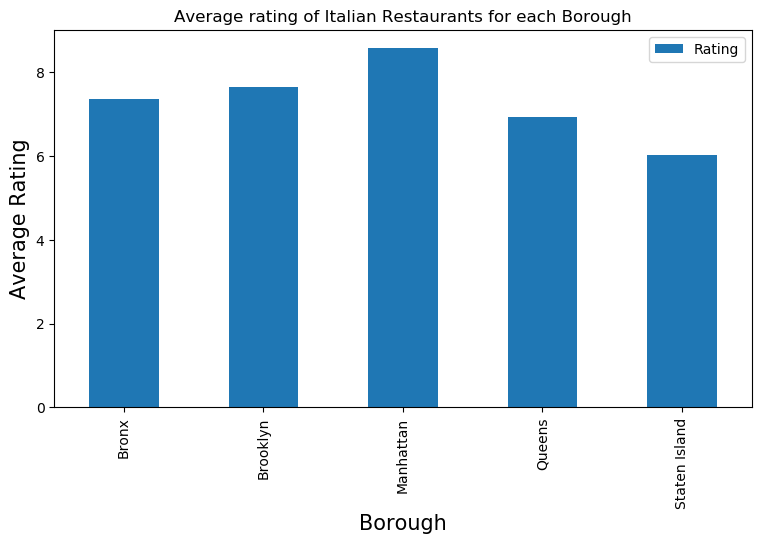

In [57]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Italian Restaurants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
Italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [58]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.5]

ny_neighborhood_stats

Neighborhood  Average Rating
17          Boerum Hill        9.100000
18     Brooklyn Heights        8.650000
20             Bushwick        9.150000
21        Carnegie Hill        8.700000
29         Civic Center        8.900000
31         Clinton Hill        8.600000
36               Corona        8.600000
41             Downtown        9.100000
45         East Village        8.600000
46    East Williamsburg        8.566667
56          Fort Greene        8.600000
63             Gramercy        8.600000
68           Greenpoint        8.800000
70    Greenwich Village        9.000000
71     Hamilton Heights        8.850000
75      Jackson Heights        8.600000
78          Lefrak City        8.500000
82         Little Italy        8.933333
85      Lower East Side        8.666667
93        Midtown South        8.600000
102                Noho        9.066667
104          North Side        8.900000
112      Pelham Gardens        8.500000
117           Rego Park        8.500000
127                Soho        8.983333
133           Sunnyside        9.100000
139             Tribeca        8.600000
140     Upper East Side        8.642857
143  Washington Heights        8.500000
153           Yorkville        8.560000

In [59]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

ny_neighborhood_stats

Borough        Neighborhood   Latitude  Longitude  Average Rating
0        Brooklyn         Boerum Hill  40.685683 -73.983748        9.100000
1        Brooklyn    Brooklyn Heights  40.695864 -73.993782        8.650000
2        Brooklyn            Bushwick  40.698116 -73.925258        9.150000
3       Manhattan       Carnegie Hill  40.782683 -73.953256        8.700000
4       Manhattan        Civic Center  40.715229 -74.005415        8.900000
5        Brooklyn        Clinton Hill  40.693229 -73.967843        8.600000
6          Queens              Corona  40.742382 -73.856825        8.600000
7        Brooklyn            Downtown  40.690844 -73.983463        9.100000
8       Manhattan        East Village  40.727847 -73.982226        8.600000
9        Brooklyn   East Williamsburg  40.708492 -73.938858        8.566667
10       Brooklyn         Fort Greene  40.688527 -73.972906        8.600000
11      Manhattan            Gramercy  40.737210 -73.981376        8.600000
12       Brooklyn          Greenpoint  40.730201 -73.954241        8.800000
13      Manhattan   Greenwich Village  40.726933 -73.999914        9.000000
14      Manhattan    Hamilton Heights  40.823604 -73.949688        8.850000
15         Queens     Jackson Heights  40.751981 -73.882821        8.600000
16         Queens         Lefrak City  40.736075 -73.862525        8.500000
17      Manhattan        Little Italy  40.719324 -73.997305        8.933333
18      Manhattan     Lower East Side  40.717807 -73.980890        8.666667
19      Manhattan       Midtown South  40.748510 -73.988713        8.600000
20      Manhattan                Noho  40.723259 -73.988434        9.066667
21       Brooklyn          North Side  40.714823 -73.958809        8.900000
22          Bronx      Pelham Gardens  40.862966 -73.841612        8.500000
23         Queens           Rego Park  40.728974 -73.857827        8.500000
24      Manhattan                Soho  40.722184 -74.000657        8.983333
25         Queens           Sunnyside  40.740176 -73.926916        9.100000
26  Staten Island           Sunnyside  40.612760 -74.097126        9.100000
27      Manhattan             Tribeca  40.721522 -74.010683        8.600000
28      Manhattan     Upper East Side  40.775639 -73.960508        8.642857
29      Manhattan  Washington Heights  40.851903 -73.936900        8.500000
30      Manhattan           Yorkville  40.775930 -73.947118        8.560000

In [60]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)


In [61]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the restaurants and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [62]:

ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [63]:

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [64]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=11)
#ny_geo = r'Borough Boundaries.geojson'
ny_geo = "https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Borough_Boundary/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson"

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.BoroName',
    fill_color='YlOrRd', 
    fill_opacity=0.5, 
    line_opacity=0.5,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
#ny_map.save('borough_rating.html')
ny_map

In [65]:
ny_borough_stats

Borough  Average Rating
0          Bronx        7.358974
1       Brooklyn        7.655769
2      Manhattan        8.576531
3         Queens        6.922892
4  Staten Island        6.032184